#### importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

#### loading data and checking its shape
we load data from ```tfidf_features.npy``` file using numpy's load API and check its shape

In [2]:
data = np.load('tfidf_features.npy',allow_pickle=True)
print(data.shape)
data

(19685, 1000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

we load data from ```headlines.csv``` and store it in a pandas dataframe

In [3]:
headlines_df = pd.read_csv('headlines.csv').set_index("idx")
headlines_df = headlines_df['headline'].astype(str)
headlines_df.info()

<class 'pandas.core.series.Series'>
Index: 19685 entries, 0 to 19684
Series name: headline
Non-Null Count  Dtype 
--------------  ----- 
19685 non-null  object
dtypes: object(1)
memory usage: 307.6+ KB


#### K-Means Clustering
preparing data for clustering by scaling and dimensionality reduction

In [4]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
pca = PCA(n_components=50)
data_pca = pca.fit_transform(data_scaled)
print(data_pca.shape)
print(f"variance : {sum(pca.explained_variance_ratio_) * 100}")

(19685, 50)
variance : 8.177707577942385


we choose optimal k for K-Means algorithm by using elbow method by visualizing WCSS(within-cluster-sum-of-squares) or inertia or distortion against k

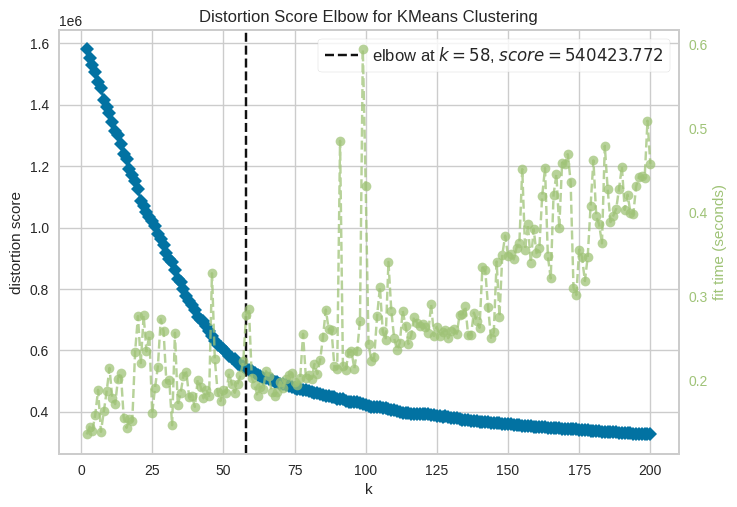

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
start = 2
end = 200+1
km = KMeans(random_state=42,init='k-means++',max_iter=700)
visualizer = KElbowVisualizer(km, k=(start,end)) #visualizes elbow
visualizer.fit(data_pca)
visualizer.show()

fitting 58 clusters as per above graph and print 10 headlines from each cluster

In [6]:
km_1 = KMeans(random_state=42,init='k-means++',max_iter=700,n_clusters=visualizer.elbow_value_)
km_1.fit(data_pca)
print(f"labels : {len(km_1.labels_)}\noptimal k : {visualizer.elbow_value_}\nscore : {visualizer.elbow_score_}",end="\n\n")
Km_1_headlines_df = pd.DataFrame({  # k = 58 clusters based on above diagram
    'headline' : headlines_df,
    'cluster' : km_1.labels_
})
for cid,hl_grp in Km_1_headlines_df.groupby('cluster'):
    print(f"cluster Id : {cid}")
    print('\n'.join(hl_grp.head(10)['headline'].tolist()),end='\n\n')

labels : 19685
optimal k : 58
score : 540423.771645252

cluster Id : 0
Dr. Anthony Fauci Responds To #FireFauci: ‘I Don’t Think That’s Going To Happen’
Mamma Mia! Amanda Seyfried Is Pregnant
My Child Is 'They,' And It's Society, Not Language, That Needs Fixing
11-Year-Old Canadian Girl Says Attacker Cut Her Hijab With Scissors
Empowering Our Daughters
Gamer Cheats On Wife, Then Gets Owned In The Most Appropriate Way Ever
What Nobody Told Me About the Terrible Twos
Drunk Birds Slur Their 'Words' Just Like Humans
Parents Are Furious About Trump's Speech To Boy Scouts
'Am I Ugly?' Videos: Young Teens Ask YouTube Users Whether They're Pretty Or Not

cluster Id : 1
Country Living Appraises A 1950s Jiffy-Way Egg Scale: What Is It Worth?
The Sharing Economy at a Crossroads
What Happened To Scott Walker?
Selecting the Right Executive Recruiter aka No Sales Weasels Please!
We Survived Hurricane Sandy. Now What?
Turning Point USA Keeps Accidentally Hiring Racists
Why What Happened To Reporters I

#### Hierarchical clustering
we take random 1000 datapoints and make dendogram to get insights

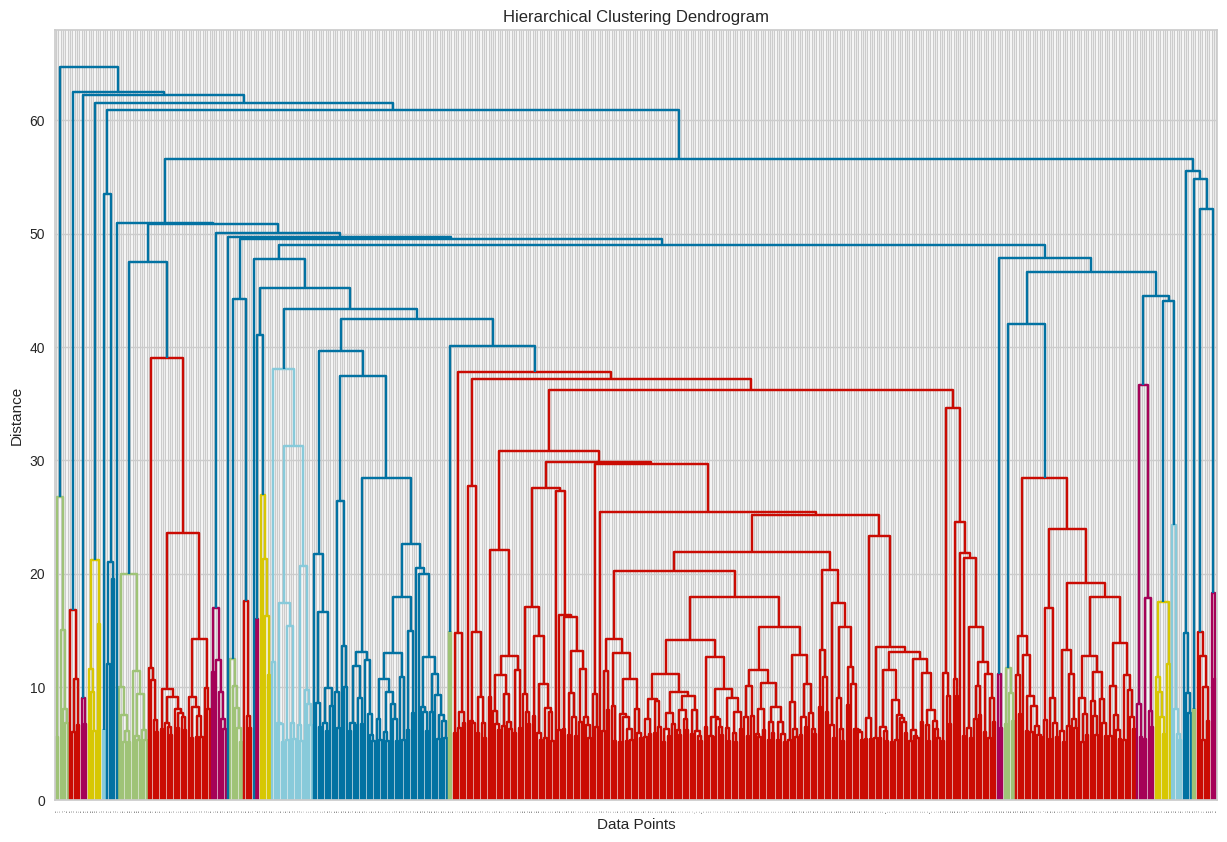

In [7]:
np.random.seed(43)
rand_ind = np.random.choice(data_pca.shape[0], size=1000, replace=False)
linkage_matrix = linkage(data_pca[rand_ind], method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, labels=np.arange(len(data_pca[rand_ind])), leaf_rotation=90, leaf_font_size=0,truncate_mode='lastp', p=500,color_threshold=40)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()      # dendogram for first 1000 data points

we plot different metrics to find optimal K

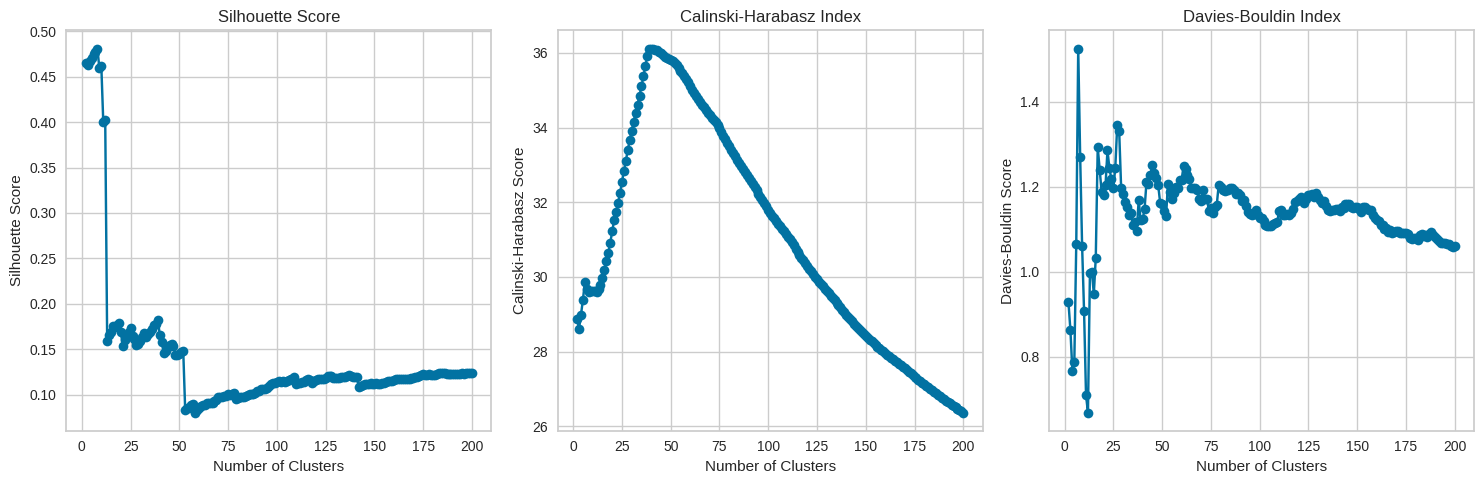

In [8]:
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []
for i in range(start,end):
    fc = fcluster(linkage_matrix, i, criterion='maxclust')
    silhouette_scores.append(silhouette_score(data_pca[rand_ind], fc))
    calinski_scores.append(calinski_harabasz_score(data_pca[rand_ind], fc))
    davies_bouldin_scores.append(davies_bouldin_score(data_pca[rand_ind], fc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

x_axis_plt = range(start,end)
# Silhouette Score
ax1.plot(x_axis_plt, silhouette_scores, marker='o')
ax1.set_title('Silhouette Score')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score')

# Calinski-Harabasz Index
ax2.plot(x_axis_plt, calinski_scores, marker='o')
ax2.set_title('Calinski-Harabasz Index')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Calinski-Harabasz Score')

# Davies-Bouldin Index
ax3.plot(x_axis_plt, davies_bouldin_scores, marker='o')
ax3.set_title('Davies-Bouldin Index')
ax3.set_xlabel('Number of Clusters')
ax3.set_ylabel('Davies-Bouldin Score')

plt.tight_layout()
plt.show()

we find 3 optimal K using these metrics
- Silhouette Score
- Calinski-Harabasz Index
- Davies-Bouldin Index

In [9]:
# For Silhouette Score, higher is better
silhouette_optimal_k = np.argmax(silhouette_scores) + start
# For Calinski-Harabasz Index, higher is better
calinski_optimal_k = np.argmax(calinski_scores) + start
# For Davies-Bouldin Index, lower is better
davies_bouldin_optimal_k = np.argmin(davies_bouldin_scores) + start
print(f"optimal K : \n silhouette : {silhouette_optimal_k}\n calinski : {calinski_optimal_k}\n davies : {davies_bouldin_optimal_k}")

optimal K : 
 silhouette : 8
 calinski : 41
 davies : 12


we train the hierarchical clustering model on first 1000 rows on optimal k = 41

In [10]:
opt_k = calinski_optimal_k
clustering = AgglomerativeClustering(n_clusters=opt_k, linkage='ward',compute_full_tree=True)
labels = clustering.fit_predict(data_pca[rand_ind])
print(len(labels))

1000


we print headlines based on cluster

In [11]:
hc_headlines_df = pd.DataFrame({
    'headline' : headlines_df[rand_ind],
    'cluster' : labels
})
for cid,hl_grp in hc_headlines_df.groupby('cluster'):
    print(f"cluster Id : {cid}")
    print('\n'.join(hl_grp.head(10)['headline'].tolist()),end='\n\n')

cluster Id : 0
What I Learned In My Daughter's First Year of School
Casa Casuarina, Gianni Versace's Former Mansion, Is In Bankruptcy (PHOTOS)
Little Girl vs. The Water Cooler: Who Will Come Out On Top?
10 Beaches Where Getting There Is Half The Fun
Building Brand Advocacy From the Inside Out
Why Won't the FDA Let Me Donate Blood?
Florida Again Leads Nation In Soaring COVID Cases Amid Delta Fears
Michaels Arts Supply Store Warns Of Possible Data Breach
#TrumpExplainsMoviePlots Is The Best Thing On The Internet Right Now. Believe Me.
One Congregation, One Family

cluster Id : 1
Republicans Think Trump Gave Them What They Wanted. They Should Think Again.
Trump Needs to Apologize to Judge Curiel
Meet The Progressive Immigrant Lawmaker Who Will Respond To Donald Trump In Spanish
Arizona GOP Attacks Dem For Voting The Same Way As 169 Republicans
Don't Let James Comey's Hearing Distract You From Republicans' Obamacare Repeal Efforts
Largest Teachers Union Already Involved In 2016 Presidentia